In [1]:
import os

In [2]:
%pwd

'D:\\Desktop\\Superteams AI\\Task 2 Vector Databases can help with Anomaly Detection\\Vector-Databases-can-help-with-Anomaly-Detection\\Research'

In [3]:
os.chdir("../")

In [4]:
%pwd

'D:\\Desktop\\Superteams AI\\Task 2 Vector Databases can help with Anomaly Detection\\Vector-Databases-can-help-with-Anomaly-Detection'

In [5]:
import logging
from pathlib import Path
logging.basicConfig(
    # filename='extract_data.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

In [6]:
import pandas as pd

# Load the CSV file into a pandas DataFrame
df = pd.read_json("Dataset/News_Category_Dataset_v3.json" , lines=True)
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [7]:
# Select the first 1000 rows of the DataFrame
df = df.head(1000)

len(df)

1000

In [8]:
logging.info("Loaded news dataset")

2024-04-19 00:55:17 - INFO - Loaded news dataset


# Loading embeddding Model

In [9]:
from sentence_transformers import SentenceTransformer

D:\Desktop\Superteams AI\Task 2 Vector Databases can help with Anomaly Detection\Vector-Databases-can-help-with-Anomaly-Detection\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
# from transformers import AutoTokenizer, AutoModel
# from pathlib import Path

# def download_model_and_tokenizer(model_name, save_path):
#     """
#     Download and save both the model and the tokenizer to the specified directory.

#     Parameters:
#         model_name (str): Name of the model to download.
#         save_path (str or Path): Path to the directory where the model and tokenizer will be saved.
#     """
#     # Create the save path if it doesn't exist
#     save_path = Path(save_path)
#     save_path.mkdir(parents=True, exist_ok=True)
    
#     # Initialize tokenizer and model
#     tokenizer = AutoTokenizer.from_pretrained(model_name)
#     model = AutoModel.from_pretrained(model_name)
    
#     # Save tokenizer
#     tokenizer.save_pretrained(save_path)
    
#     # Save model
#     model.save_pretrained(save_path)

# # Example usage
# model_name = 'sentence-transformers/all-MiniLM-L12-v2'  # Model name to download
# save_path = Path("MiniLM-L12-v2/")  # Path where model and tokenizer will be saved
# download_model_and_tokenizer(model_name, save_path)


In [11]:
from transformers import AutoTokenizer, AutoModel

def load_model_and_tokenizer(model_path):
    """
    Load the model and tokenizer from the specified directory.

    Parameters:
        model_path (str or Path): Path to the directory containing the saved model and tokenizer.

    Returns:
        tokenizer (transformers.PreTrainedTokenizer): Loaded tokenizer.
        model (transformers.PreTrainedModel): Loaded model.
    """
    model_path = Path(model_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModel.from_pretrained(model_path)
    return tokenizer, model

# Load the model and tokenizer
model_path = Path("MiniLM-L12-v2/")
tokenizer, model = load_model_and_tokenizer(model_path)

In [12]:
logging.info("Initialized SentenceTransformer model")

2024-04-19 00:55:26 - INFO - Initialized SentenceTransformer model


In [13]:
df['news'] = df.apply(lambda row: row['headline'] + ' ' + row['short_description'], axis=1)
df.head()

,link,headline,category,short_description,authors,date,news
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23,Over 4 Million Americans Roll Up Sleeves For O...
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23,"American Airlines Flyer Charged, Banned For Li..."
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23,23 Of The Funniest Tweets About Cats And Dogs ...
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23,The Funniest Tweets From Parents This Week (Se...
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22,Woman Who Called Cops On Black Bird-Watcher Lo...


# embedding the data 

In [14]:
import torch

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def generate_embedding(text):
    # Tokenize input text
    encoded_input = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    # Compute token embeddings with model
    with torch.no_grad():
        model_output = model(**encoded_input)
    # Perform mean pooling
    sentence_embedding = mean_pooling(model_output, encoded_input['attention_mask'])
    # Convert to numpy for FAISS compatibility and ensure it's 2D
    return sentence_embedding.cpu().numpy().reshape(1, -1)

In [15]:
# Generate embeddings for the 'input' column
df['encoded_news'] = df['news'].apply(lambda x: generate_embedding(x)[0].tolist())
df.head()

,link,headline,category,short_description,authors,date,news,encoded_news
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23,Over 4 Million Americans Roll Up Sleeves For O...,"[-0.1485874205827713, 0.02155824564397335, -0...."
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23,"American Airlines Flyer Charged, Banned For Li...","[0.16428081691265106, 0.09380828589200974, -0...."
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23,23 Of The Funniest Tweets About Cats And Dogs ...,"[-0.15815997123718262, -0.2952045798301697, 0...."
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23,The Funniest Tweets From Parents This Week (Se...,"[-0.23049014806747437, 0.1791965365409851, 0.0..."
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22,Woman Who Called Cops On Black Bird-Watcher Lo...,"[-0.045801933854818344, -0.04670226201415062, ..."


In [16]:
# # Save the DataFrame to a CSV file
# save_path = "Dataset/encoded_news_data.csv"
# df.to_csv(save_path, index=False)


In [17]:
# import pandas as pd

# # Path to the CSV file
# csv_file_path = "Dataset/encoded_news_data.csv"

# # Read the CSV file into a pandas DataFrame
# df = pd.read_csv(csv_file_path)

# # Display the first few rows of the DataFrame
# df.head()


# Apply t-SNE for dimensionality reduction

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

In [20]:
# import ast  # Import the ast module to parse string representations of lists

# # Convert string representation of lists to actual lists
# df['encoded_news'] = df['encoded_news'].apply(ast.literal_eval)

# Convert the lists to numpy array


In [21]:
X = np.array(df['encoded_news'].tolist())
# Increase the perplexity value (default is 30)
tsne = TSNE(random_state=0, n_iter=1000, perplexity=500)
tsne_results = tsne.fit_transform(X)

df_tsne = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
df_tsne['Class Name'] = df['category']  # Using 'title' as a placeholder for 'Class Name'
df_tsne['news'] = df['news'] 
# df_tsne['encoded_news'] = df['encoded_news']
df_tsne.head()

,TSNE1,TSNE2,Class Name,news
0,1.000617,0.805732,U.S. NEWS,Over 4 Million Americans Roll Up Sleeves For O...
1,-0.557663,-0.134287,U.S. NEWS,"American Airlines Flyer Charged, Banned For Li..."
2,0.702444,-1.796895,COMEDY,23 Of The Funniest Tweets About Cats And Dogs ...
3,0.631628,-1.466466,PARENTING,The Funniest Tweets From Parents This Week (Se...
4,-0.219676,-0.351824,U.S. NEWS,Woman Who Called Cops On Black Bird-Watcher Lo...


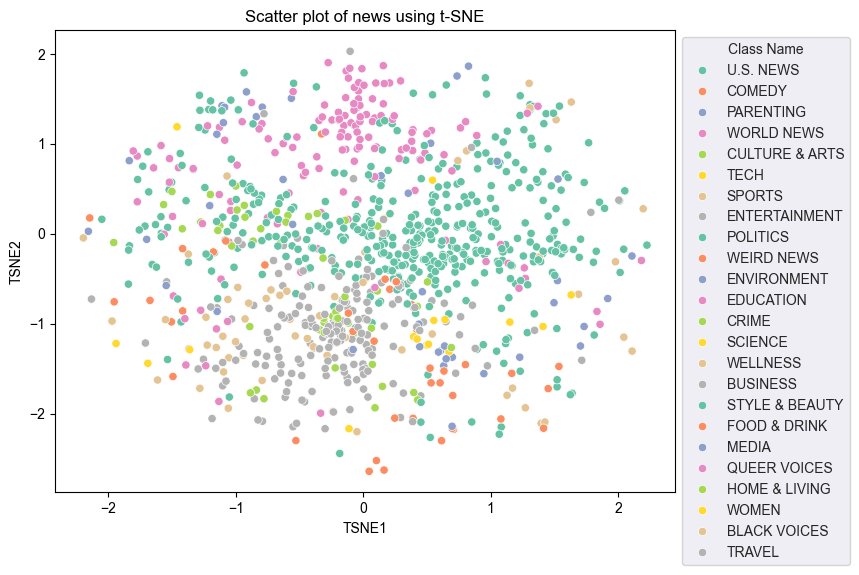

In [22]:
# Plot t-SNE results
fig, ax = plt.subplots(figsize=(8, 6))
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Class Name', palette='Set2')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news using t-SNE')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.show()

# Outlier detection

In [29]:
# Function to get centroids of each class
def get_centroids(df_tsne):
    centroids = df_tsne.drop(columns=['news']).groupby('Class Name').mean()
    return centroids

centroids = get_centroids(df_tsne)

# Function to detect outliers
def calculate_euclidean_distance(p1, p2):
    return np.sqrt(np.sum(np.square(p1 - p2)))

def detect_outlier(df, emb_centroids, radius):
    outlier_indices = []
    for idx, row in df.iterrows():
        class_name = row['Class Name']
        dist = calculate_euclidean_distance(np.array([row['TSNE1'], row['TSNE2']]),
                                            np.array([emb_centroids.loc[class_name, 'TSNE1'],
                                                      emb_centroids.loc[class_name, 'TSNE2']]))
        if dist > radius:
            outlier_indices.append(idx)
    return outlier_indices

In [31]:
# Assuming df_tsne and centroids are already defined DataFrames
range_ = np.arange(0.01, 1.0, 0.05).round(decimals=2).tolist()
outliers_list = []

for i in range_:
    outliers = detect_outlier(df_tsne, centroids, i)
    outliers_list.append(outliers)

# Combine all outlier indices into a single list
all_outliers = [idx for sublist in outliers_list for idx in sublist]

# Update the 'Outlier' column in df_tsne
df_tsne['Outlier'] = df_tsne.index.isin(all_outliers)
df_tsne.head()


,TSNE1,TSNE2,Class Name,news,Outlier
0,1.000617,0.805732,U.S. NEWS,Over 4 Million Americans Roll Up Sleeves For O...,True
1,-0.557663,-0.134287,U.S. NEWS,"American Airlines Flyer Charged, Banned For Li...",True
2,0.702444,-1.796895,COMEDY,23 Of The Funniest Tweets About Cats And Dogs ...,True
3,0.631628,-1.466466,PARENTING,The Funniest Tweets From Parents This Week (Se...,True
4,-0.219676,-0.351824,U.S. NEWS,Woman Who Called Cops On Black Bird-Watcher Lo...,True


In [41]:
# Filter out rows where 'Outlier' is False
df_tsne = df_tsne[df_tsne['Outlier'] == True]

In [42]:
num_outliers = [len(outliers) for outliers in outliers_list]


2024-04-19 01:08:58 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-04-19 01:08:58 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


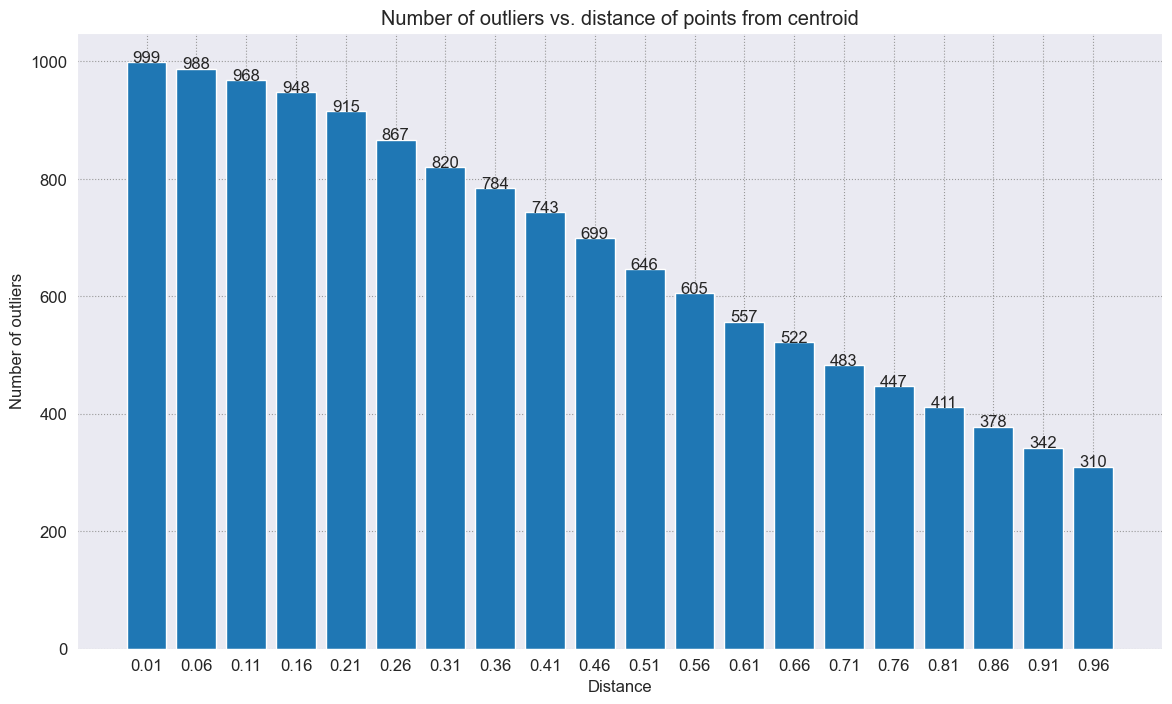

In [43]:
import matplotlib.pyplot as plt

# Plot range_ and num_outliers
fig = plt.figure(figsize=(14, 8))
plt.rcParams.update({'font.size': 12})
plt.bar(list(map(str, range_)), num_outliers)
plt.title("Number of outliers vs. distance of points from centroid")
plt.xlabel("Distance")
plt.ylabel("Number of outliers")
for i in range(len(range_)):
    plt.text(i, num_outliers[i], num_outliers[i], ha='center')

plt.show()


In [44]:
def get_outlier_texts(df, class_name):
    # Filter the DataFrame to get outliers of the specified category
    outliers = df[(df['Class Name'] == class_name) & df['Outlier']]
    
    # Extract the outlier texts
    outlier_texts = outliers['news'].tolist()
    
    return outlier_texts

# Example usage:
outlier_texts = get_outlier_texts(df_tsne, 'TECH')
for idx, text in enumerate(outlier_texts, start=1):
    print(f"Outlier {idx}: {text}\n")


Outlier 1: Twitch Bans Gambling Sites After Streamer Scams Folks Out Of $200,000 One man's claims that he scammed people on the platform caused several popular streamers to consider a Twitch boycott.

Outlier 2: TikTok Search Results Riddled With Misinformation: Report A U.S. firm that monitors false online claims reports that searches for information about prominent news topics on TikTok are likely to turn up results riddled with misinformation.

Outlier 3: Citing Imminent Danger Cloudflare Drops Hate Site Kiwi Farms Cloudflare CEO Matthew Prince had previously resisted calls to block the site.

Outlier 4: Instagram And Facebook Remove Posts Offering Abortion Pills Facebook and Instagram began removing some of these posts, just as millions across the U.S. were searching for clarity around abortion access.

Outlier 5: Google Engineer On Leave After He Claims AI Program Has Gone Sentient Artificially intelligent chatbot generator LaMDA wants “to be acknowledged as an employee of Google 

In [45]:
def get_outlier_paragraph(df, class_name):
    # Filter the DataFrame to get outliers of the specified category
    outliers = df[(df['Class Name'] == class_name) & df['Outlier']]
    
    # Extract the outlier texts
    outlier_texts = outliers['news'].tolist()
    
    # Concatenate all outlier texts into one paragraph
    outlier_paragraph = ' '.join(outlier_texts)
    
    return outlier_paragraph

# Example usage:
outlier_paragraph = get_outlier_paragraph(df_tsne, 'TECH')
print(outlier_paragraph)


Twitch Bans Gambling Sites After Streamer Scams Folks Out Of $200,000 One man's claims that he scammed people on the platform caused several popular streamers to consider a Twitch boycott. TikTok Search Results Riddled With Misinformation: Report A U.S. firm that monitors false online claims reports that searches for information about prominent news topics on TikTok are likely to turn up results riddled with misinformation. Citing Imminent Danger Cloudflare Drops Hate Site Kiwi Farms Cloudflare CEO Matthew Prince had previously resisted calls to block the site. Instagram And Facebook Remove Posts Offering Abortion Pills Facebook and Instagram began removing some of these posts, just as millions across the U.S. were searching for clarity around abortion access. Google Engineer On Leave After He Claims AI Program Has Gone Sentient Artificially intelligent chatbot generator LaMDA wants “to be acknowledged as an employee of Google rather than as property," says engineer Blake Lemoine. Face

# RAG using Llama2

In [56]:
query = "write a summary for this ? "

In [68]:
print(str(query + outlier_paragraph)[:512])

write a summary for this ? Twitch Bans Gambling Sites After Streamer Scams Folks Out Of $200,000 One man's claims that he scammed people on the platform caused several popular streamers to consider a Twitch boycott. TikTok Search Results Riddled With Misinformation: Report A U.S. firm that monitors false online claims reports that searches for information about prominent news topics on TikTok are likely to turn up results riddled with misinformation. Citing Imminent Danger Cloudflare Drops Hate Site Kiwi Fa


In [69]:
from llama2backend import generate_text

RAG_answer = generate_text(str(query + outlier_paragraph)[:512])

Llama.generate: prefix-match hit


... Cloudflare, a company that provides web infrastructure services, has dropped its support for the hate site Kiwi Farms after citing imminent danger to users.
Twitch Bans Gambling Sites After Streamer Scams Folks Out Of $200,000
A popular streamer on Twitch has been banned from the platform after he scammed viewers out of over $200,000 through a gambling scheme. The streamer, who goes by the name "AdventureZ," had been promoting a gambling site on his channel for months, encouraging his viewers to deposit money and participate in games of chance. However, the site was not legitimate and AdventureZ was not authorized to promote it. As a result, Twitch has banned AdventureZ from the platform and is working with law enforcement to investigate the matter further.
The incident has raised concerns about gambling on Twitch and the potential for fraudulent activities to occur on the platform. In response, Twitch has announced that it will be implementing new measures to prevent gambling-rela


llama_print_timings:        load time =     316.42 ms
llama_print_timings:      sample time =     148.90 ms /   256 runs   (    0.58 ms per token,  1719.31 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_print_timings:        eval time =    8302.56 ms /   256 runs   (   32.43 ms per token,    30.83 tokens per second)
llama_print_timings:       total time =   11051.11 ms /   257 tokens


In [70]:
RAG_answer

'... Cloudflare, a company that provides web infrastructure services, has dropped its support for the hate site Kiwi Farms after citing imminent danger to users.\nTwitch Bans Gambling Sites After Streamer Scams Folks Out Of $200,000\nA popular streamer on Twitch has been banned from the platform after he scammed viewers out of over $200,000 through a gambling scheme. The streamer, who goes by the name "AdventureZ," had been promoting a gambling site on his channel for months, encouraging his viewers to deposit money and participate in games of chance. However, the site was not legitimate and AdventureZ was not authorized to promote it. As a result, Twitch has banned AdventureZ from the platform and is working with law enforcement to investigate the matter further.\nThe incident has raised concerns about gambling on Twitch and the potential for fraudulent activities to occur on the platform. In response, Twitch has announced that it will be implementing new measures to prevent gambling-